In [199]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import osmnx as ox
import networkx as nx

In [200]:
import os
cities = [pd.read_csv("../data/big-cities-raw/"+ i) for i in os.listdir("../data/big-cities-raw/")]
cities = pd.concat(cities, ignore_index=True)
cities = cities[~cities.Location.str.contains("\\[Note")]

cities.columns = cities.columns.str.lower()

In [201]:
cities.head()

,location,latitude,longitude
0,"Funafuti, Tuvalu",-8.520470,179.199585
1,"Cape Town, South Africa",-33.924870,18.424055
2,"Metro Manila, Philippines",14.609054,121.022255
3,"Quezon City, Philippines",14.676041,121.043701
4,"Yaren, Nauru",-0.547520,166.917267


In [202]:
cities['lat'] = cities['latitude']
cities['lon'] = cities['longitude']

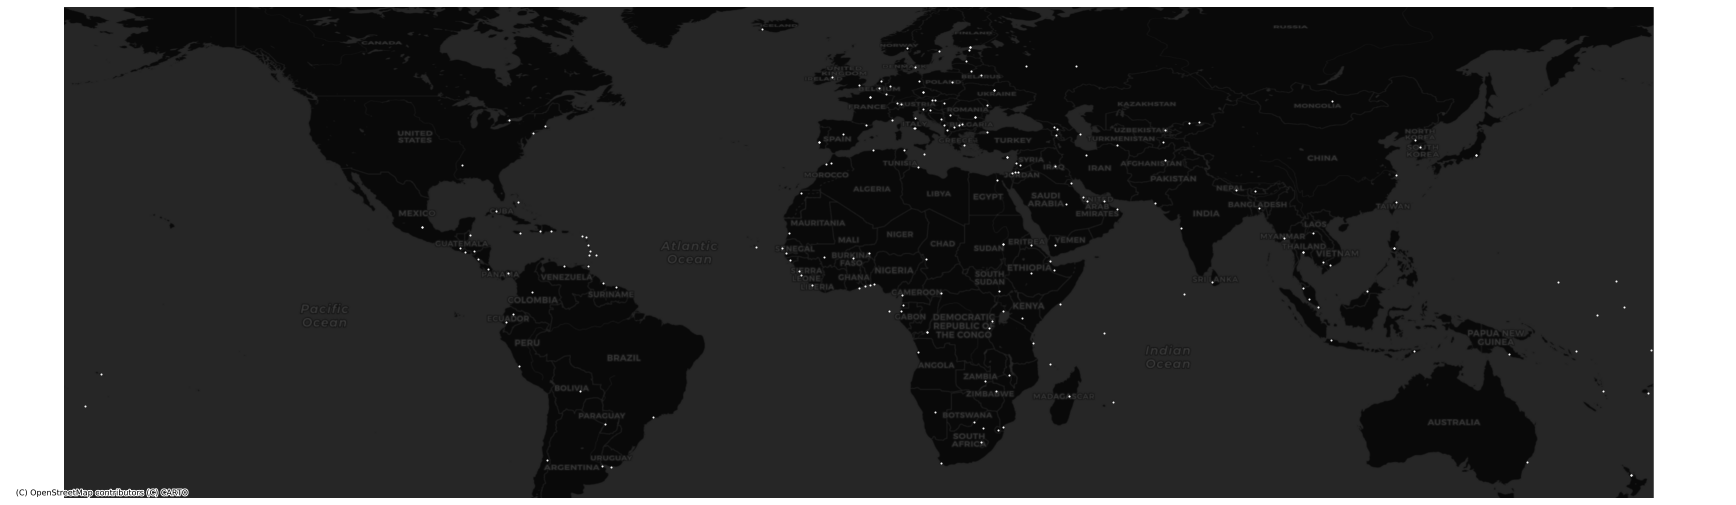

In [203]:
gdf = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.lon, cities.lat))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(24, 12), 
                       facecolor='w',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

cities.plot.scatter("lon", "lat", ax=ax,
                    c='w', s=1.2, alpha=0.9)

ax.set_axis_off()
cx.add_basemap(ax, crs={'init': 'epsg:4326'},
               source=cx.providers.CartoDB.DarkMatter)

fig.savefig('big-cities.png', transparent=True, dpi=120, bbox_inches='tight')    

In [204]:
populations = pd.read_html("https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population")
populations = populations[0]

populations = populations.iloc[1:, 0:4]

populations.columns = ['rank', 'country', 'region', 'population']
populations['country'] = populations.country.str.replace("DR ", "")

In [205]:
populations.head()

,rank,country,region,population
1,1,China,Asia,1411778724
2,2,India,Asia,1385497588
3,3,United States,Americas,332869986
4,4,Indonesia,Asia,271350000
5,5,Pakistan,Asia,225200000


In [206]:
def rejigger(name):
    if len(name) > 2:
        new_name = name[2] + " " + name[1]
        return new_name
    
    else:
        return name[1]

In [207]:
cities['country'] = [rejigger(i) for i in cities.location.str.split(", ")]
cities['city'] = [i[0] for i in cities.location.str.split(", ")]

cities['country'] = cities.country.str.replace(" of America", "")
cities['country'] = cities.country.str.replace("Democratic Republic of the ", "")
cities['country'] = cities.country.str.replace("Côte d'Ivoire", "Ivory Coast")
cities['country'] = cities.country.str.replace("DR Congo", "Congo")

In [208]:
cities.head()

,location,latitude,longitude,lat,lon,geometry,country,city
0,"Funafuti, Tuvalu",-8.520470,179.199585,-8.520470,179.199585,POINT (179.19959 -8.52047),Tuvalu,Funafuti
1,"Cape Town, South Africa",-33.924870,18.424055,-33.924870,18.424055,POINT (18.42405 -33.92487),South Africa,Cape Town
2,"Metro Manila, Philippines",14.609054,121.022255,14.609054,121.022255,POINT (121.02226 14.60905),Philippines,Metro Manila
3,"Quezon City, Philippines",14.676041,121.043701,14.676041,121.043701,POINT (121.04370 14.67604),Philippines,Quezon City
4,"Yaren, Nauru",-0.547520,166.917267,-0.547520,166.917267,POINT (166.91727 -0.54752),Nauru,Yaren


In [209]:
cities = cities.drop([45, 41, 196], axis=0)
cities = cities.drop_duplicates()

In [210]:
cities.to_csv("big-cities.csv")

In [212]:
edges = list()
nodes = list()

graphs = list()

cities['city'] = cities['location']

In [213]:
top = populations.iloc[0:99]
top = cities[cities.country.isin(top.country)]

In [214]:
top = top[~top.city.str.contains("Quezon City|Rhine-Ruhr")]

In [215]:
for i in np.arange(0, top.shape[0]):
    
    city = top.iloc[i]
    
    print(city.city)
    
    G = ox.graph_from_point((city['latitude'], city['longitude']), 
                            dist=2000, 
                            network_type='drive')
    
    N, E = ox.graph_to_gdfs(G)
    
    N['city'] = city.city
    E['city'] = city.city
    
    nodes.append(N)
    edges.append(E)
    
    graphs.append(G)
    
edges = gpd.GeoDataFrame(pd.concat(edges, ignore_index=False))
nodes = gpd.GeoDataFrame(pd.concat(nodes, ignore_index=False))

Cape Town, South Africa


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Metro Manila, Philippines


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Harare, Zimbabwe


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Lusaka, Zambia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Sana'a, Yemen


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Ho Chi Minh City, Vietnam


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Caracas, Venezuela


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Tashkent, Uzbekistan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


New York City, United States of America


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


London, United Kingdom


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Dubai, United Arab Emirates


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Kyiv, Ukraine


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3

Kampala, Uganda


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Istanbul, Turkey


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Tunis, Tunisia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Bangkok, Thailand


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Dar es Salaam, Tanzania


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Dushanbe, Tajikistan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


New Taipei, Taiwan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Damascus, Syria


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Stockholm, Sweden


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Khartoum, Sudan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Omdurman, Sudan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Colombo, Sri Lanka


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Madrid, Spain


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Johannesburg, South Africa


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Mogadishu, Somalia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Dakar, Senegal


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Riyadh, Saudi Arabia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Kigali, Rwanda


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Moscow, Russia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Bucharest, Romania


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Lisbon, Portugal


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Warsaw, Poland


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Lima, Peru


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Port Moresby, Papua New Guinea


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3

Karachi, Pakistan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Lagos, Nigeria


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Niamey, Niger


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Amsterdam, Netherlands


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Kathmandu, Nepal


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Yangon, Myanmar


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Maputo, Mozambique


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Casablanca, Morocco


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Mexico City, Mexico


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Bamako, Mali


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Kuala Lumpur, Malaysia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Lilongwe, Malawi


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3

Antananarivo, Madagascar


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


Seoul, Korea, South


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Pyongyang, Korea, North


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3

Nairobi, Kenya


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Almaty, Kazakhstan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3

Amman, Jordan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Tokyo, Japan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Rome, Italy


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Jerusalem, Israel


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Baghdad, Iraq


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Tehran, Iran


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Jakarta, Indonesia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Mumbai, India


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Budapest, Hungary


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Tegucigalpa, Honduras


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Port-au-Prince, Haiti


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3

Conakry, Guinea


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Guatemala City, Guatemala


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Athens, Greece


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Accra, Ghana


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Berlin, Germany


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Paris, France


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Addis Ababa, Ethiopia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Cairo, Egypt


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Guayaquil, Ecuador


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Quito, Ecuador


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Santo Domingo, Dominican Republic


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Prague, Czech Republic


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Havana, Cuba


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Abidjan, Côte d'Ivoire


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Kinshasa, Congo, Democratic Republic of the


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Bogotá, Colombia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Shanghai, China


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Santiago, Chile


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


N'Djamena, Chad


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Toronto, Canada


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Douala, Cameroon


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Phnom Penh, Cambodia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Bujumbura, Burundi


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Ouagadougou, Burkina Faso


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


São Paulo, Brazil


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Santa Cruz de la Sierra, Bolivia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Cotonou, Benin


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Brussels, Belgium


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Minsk, Belarus


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3

Dhaka, Bangladesh


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Baku, Azerbaijan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Vienna, Austria


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Sydney, Australia


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Buenos Aires, Argentina


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Luanda, Angola


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Algiers, Algeria


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Kabul, Afghanistan


/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


In [219]:
top['city'] = top.city.str.replace("Metro ", "")

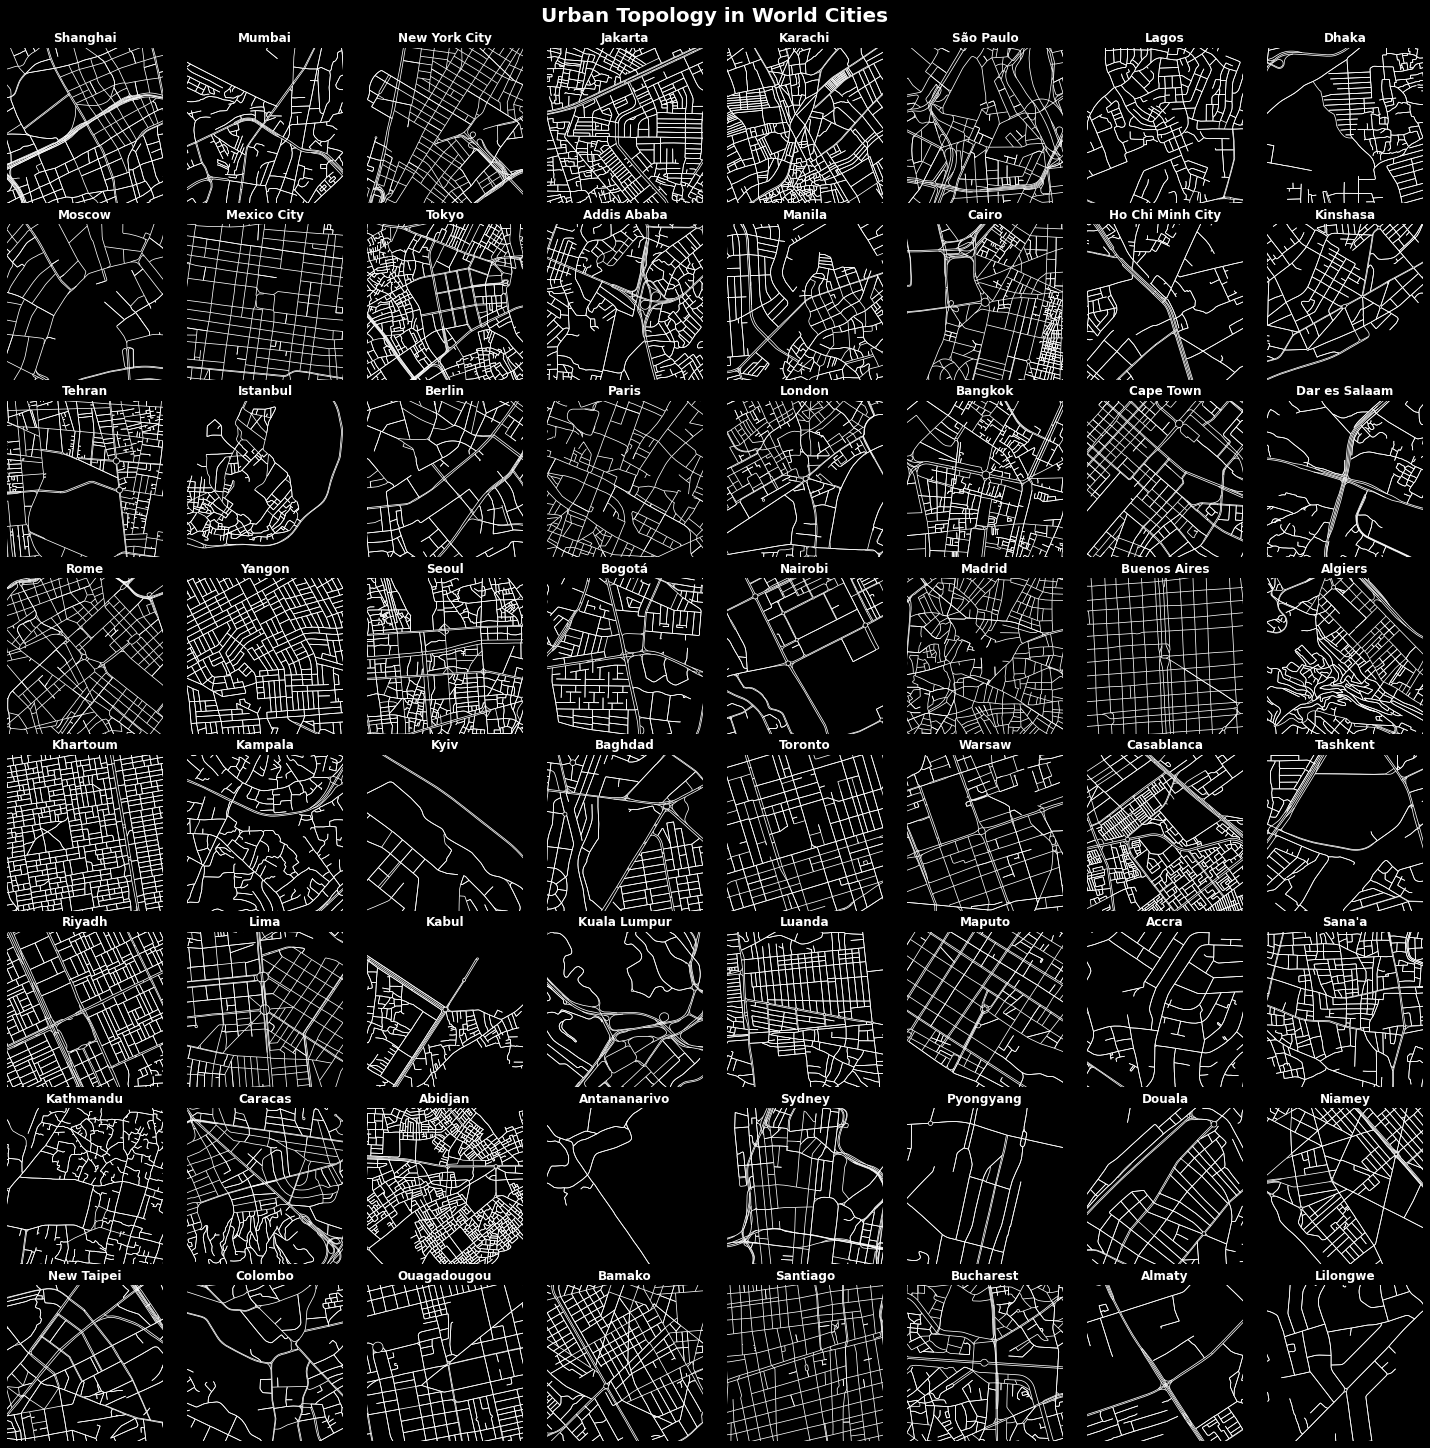

In [220]:
fig, axs = plt.subplots(8, 8, figsize=(20, 20), 
                        facecolor='k',
                        constrained_layout=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 64):
    
    country = populations.iloc[i]
    city = top[top.country==country.country]
    
    node = nodes[nodes['city']==city.iloc[0]['location']]
    edge = edges[edges['city']==city.iloc[0]['location']]
    
    edge.plot(ax=axs[i], color='w', lw=0.75)
    
    bbox = ox.utils_geo.bbox_from_point((city.iloc[0]['lat'], city.iloc[0]['lon']), 800, project_utm=False)
    
    title = city.city.iloc[0]
    title, *_ = title.split(", ")
    
    north, south, east, west = bbox
    axs[i].set_ylim((south, north))
    axs[i].set_xlim((west, east))
    axs[i].set_title(title, color='w', weight='bold')

    axs[i].margins(0)
    axs[i].axis('off')
    
fig.suptitle('Urban Topology in World Cities', color='w', size=20, weight='bold')
fig.savefig('urban-topology.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')